In [28]:
import pandas as pd
import os 
import warnings 
from src.files import XMLFile, FASTAFile, GBFFFile
from src import get_genome_id
from src.sampler import Sampler 
from src.dataset import Dataset
from torch.utils.data import DataLoader
from utils import * 
from src.genome import ReferenceGenome
from src.tools import NCBIDatasets, Prodigal
import glob
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.gridspec import GridSpec
import dataframe_image as dfi
from sklearn.model_selection import train_test_split
from src.classifier import Classifier
from sklearn.metrics import balanced_accuracy_score, confusion_matrix
from sklearn.linear_model import LogisticRegression

%load_ext autoreload 
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [29]:
ref_out_df = load_ref_out()
ref_out_df = remove_partial(ref_out_df)

ref_out_fp_df = ref_out_df[ref_out_df.n_valid_hits == 0].copy()
ref_out_tp_df = ref_out_df[(ref_out_df.n_valid_hits > 0)].copy()

genome_metadata_df = load_genome_metadata()

load_ref_out: 100%|██████████| 137/137 [00:03<00:00, 35.02it/s]


remove_partial: Removing 4364 instances marked as partial by both Prodigal and RefSeq from the DataFrame.


In [30]:
ref_out_df.columns

Index(['n_hits', 'n_valid_hits', 'n_same_strand_hits', 'ref_locus_tag',
       'ref_feature', 'in_frame_hit', 'start_aligned_hit', 'stop_aligned_hit',
       'hit_overlap', 'ref_contig_id', 'ref_strand', 'ref_start', 'ref_stop',
       'ref_partial', 'ref_product', 'ref_note', 'ref_protein_id', 'ref_seq',
       'ref_pseudo', 'ref_inference', 'ref_experiment', 'ref_evidence_type',
       'ref_evidence_category', 'ref_evidence_details', 'ref_evidence_source',
       'ref_used_pgap', 'ref_length', 'ref_stop_codon', 'ref_start_codon',
       'start', 'stop', 'strand', 'ID', 'partial', 'start_type', 'rbs_motif',
       'rbs_spacer', 'gc_content', 'seq', 'contig_id', 'stop_codon',
       'start_codon', 'genome_id'],
      dtype='object')

In [31]:
print('Maximum false positive length:', ref_out_fp_df.seq.apply(len).max())
print('Minimum false positive length:', ref_out_fp_df.seq.apply(len).min())

Maximum false positive length: 6469
Minimum false positive length: 29


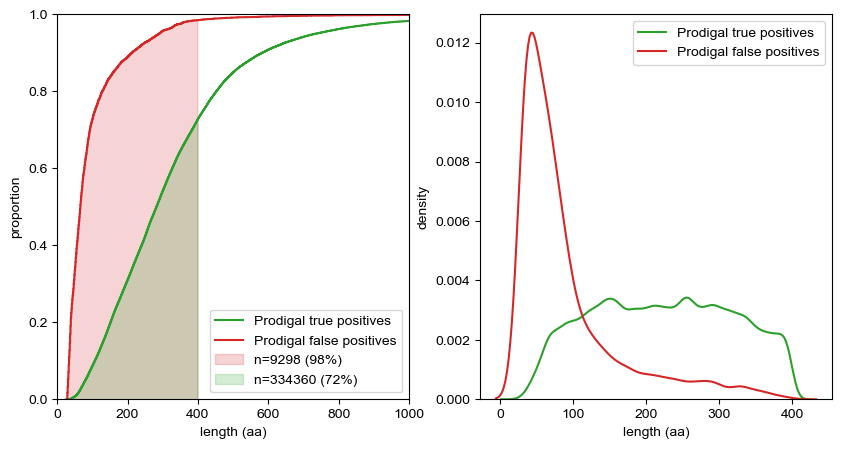

In [32]:
def figure_1(ref_out_df, path:str='../figures/filter-figure_1.png'):

    ref_out_fp_df = ref_out_df[ref_out_df.n_valid_hits == 0].copy()
    ref_out_tp_df = ref_out_df[(ref_out_df.n_valid_hits > 0)].copy()

    fig, axes = plt.subplots(ncols=2, figsize=(10, 5))

    ax = axes[0]
    ax = sns.ecdfplot(ref_out_tp_df.seq.apply(len), ax=ax, color='tab:green', label=f'Prodigal true positives')
    ax = sns.ecdfplot(ref_out_fp_df.seq.apply(len), ax=ax, color='tab:red', label=f'Prodigal false positives')

    x_tp, y_tp = ax.get_lines()[0].get_data()
    x_fp, y_fp = ax.get_lines()[1].get_data()

    x_tp, x_fp, y_tp, y_fp = x_tp[1:], x_fp[1:], y_tp[1:], y_fp[1:]

    max_length = 400

    n_tp = (x_tp < max_length).sum()
    n_fp = (x_fp < max_length).sum()
    p_tp = int(n_tp * 100 / len(x_tp))
    p_fp = int(n_fp * 100 / len(x_fp))

    ax.fill_between(x_fp[x_fp < max_length], y_fp[x_fp < max_length], color='tab:red', alpha=0.2, label=f'n={n_fp} ({p_fp}%)')
    ax.fill_between(x_tp[x_tp < max_length], y_tp[x_tp < max_length], color='tab:green', alpha=0.2, label=f'n={n_tp} ({p_tp}%)')
    ax.set_xlim(0, 1000)
    ax.set_ylabel('proportion')
    ax.set_xlabel('length (aa)')
    ax.legend()

    ax = axes[1]
    ref_out_tp_df = ref_out_tp_df[ref_out_tp_df.seq.apply(len) < max_length]
    ref_out_fp_df = ref_out_fp_df[ref_out_fp_df.seq.apply(len) < max_length]
    sns.kdeplot(ref_out_tp_df.seq.apply(len), ax=ax, color='tab:green', label=f'Prodigal true positives')
    sns.kdeplot(ref_out_fp_df.seq.apply(len), ax=ax, color='tab:red', label=f'Prodigal false positives')
    ax.legend()
    ax.set_ylabel('density')
    ax.set_xlabel('length (aa)')

    plt.show()

figure_1(ref_out_df)

In [33]:
# The length distributions differ enough that I am a little worried that the model will take the "easy" way out and just
# learn sequence length. 
dataset_df = pd.concat([ref_out_fp_df.assign(label=1), ref_out_tp_df.assign(label=0)], axis=0)
dataset_df = dataset_df[dataset_df.seq.apply(len) < 400]

train_dataset_df, test_dataset_df = train_test_split(dataset_df, test_size=0.2, train_size=0.8)

In [34]:
def fix_dtypes(df:pd.DataFrame):
    df = df.copy().convert_dtypes()
    for col in df.columns:
        if df[col].dtype == 'string[python]':
            df[col] = df[col].fillna('none')
        if df[col].dtype == 'boolean':
            df[col] = df[col].fillna(False)
        if df[col].dtype in ['Int64', 'Float64']:
            df[col].fillna(-1)
    return df 

fix_dtypes(train_dataset_df).to_csv('../data/filter_dataset_train.csv')
fix_dtypes(test_dataset_df).to_csv('../data/filter_dataset_test.csv')

In [35]:
print((train_dataset_df.label == 0).sum() / len(train_dataset_df))
print((train_dataset_df.label == 1).sum() / len(train_dataset_df))
print((test_dataset_df.label == 0).sum() / len(test_dataset_df))
print((test_dataset_df.label == 1).sum() / len(test_dataset_df))

0.9729236230840299
0.027076376915970115
0.973025664901356
0.026974335098644008


In [36]:
pred_out_df = pd.read_csv('../data/predict.out/filter_dataset_test.predict.csv', index_col=0)
# Add the metadata to the predictions. 
pred_out_df = pred_out_df.merge(ref_out_df, left_index=True, right_index=True, how='left')
pred_out_df = pred_out_df.merge(genome_metadata_df[['species']], left_on='genome_id', right_index=True, how='left')


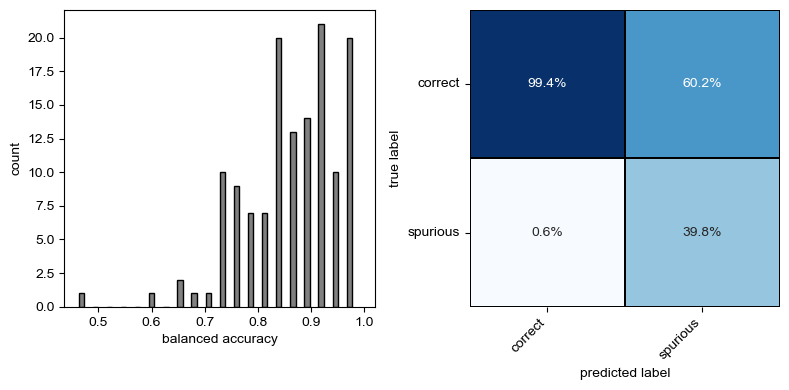

125003 bytes written to file /tmp/tmpj72634mj/temp.png


,acc.,num. pred. false pos.,num. false pos.,num. pred. true pos.,num. true pos.
species,,,,,
Acholeplasma_D palmae,0.462871,15,1,188,202
Halanaerobium praevalens,0.618197,5,4,293,294
Caulobacter zeae,0.657550,14,3,702,713
Spirochaeta_A thermophila,0.660215,6,6,310,310
Desulfovirgula thermocuniculi,0.699580,17,7,466,476
...,...,...,...,...,...
Spirochaeta_B africana,0.988732,12,4,347,355
Pseudothermotoga_B elfii,0.990415,10,4,307,313
Hippea sp000526195,0.991968,7,3,245,249


In [65]:
# First thing I want to look at is the accuracy per genome. 
fig, axes = plt.subplots(ncols=2, layout='tight', figsize=(8, 4))

ax = axes[0]
accs = pred_out_df.groupby('genome_id').apply(lambda df : balanced_accuracy_score(df.label, df.filter_balance_classes_and_lengths_label), include_groups=False)
ax.hist(accs, bins=20, color='gray', width=0.01, edgecolor='black')
ax.set_xlabel('balanced accuracy')
ax.set_ylabel('count')

ax = axes[1]
labels = ['correct', 'spurious']
matrix = confusion_matrix(pred_out_df.label.values, pred_out_df.filter_balance_classes_and_lengths_label.values) #, labels=sorted(pred_out_df.label.unique()))
matrix = pd.DataFrame(matrix, columns=labels, index=labels)
matrix = matrix.apply(lambda x: x/x.sum(), axis=0) # Normalize the matrix.

sns.heatmap(matrix, ax=ax, annot=True, cbar=False, linecolor='black', lw=0.2, fmt='.1%', cmap='Blues') # fmt='.1%',

# Rotate the tick labels on the x-axis of each subplot.
ax.set_xticks(np.arange(len(labels)) + 0.5, matrix.columns, rotation=45, ha='right')
ax.set_yticks(np.arange(len(labels)) + 0.5, matrix.columns, rotation=0)
ax.set_xlabel('predicted label')
ax.set_ylabel('true label')

plt.show()

# The UserWarning from scikitlearn is because some of the genomes have no Prodigal false positives in the testing set. 

def table_1(pred_out_df:pd.DataFrame, path:str='../figures/filter-table_1.png'):
    table_df = dict()

    table_df['acc.'] = pred_out_df.groupby('species').apply(lambda df : balanced_accuracy_score(df.label, df.filter_balance_classes_and_lengths_label) , include_groups=False)
    
    table_df['num. pred. false pos.'] = pred_out_df.groupby('species').apply(lambda df : (df.filter_balance_classes_and_lengths_label == 1).sum(), include_groups=False)
    table_df['num. false pos.'] = pred_out_df.groupby('species').apply(lambda df : (df.label == 1).sum(), include_groups=False)
    table_df['num. pred. true pos.'] = pred_out_df.groupby('species').apply(lambda df : (df.filter_balance_classes_and_lengths_label == 0).sum(), include_groups=False)
    table_df['num. true pos.'] = pred_out_df.groupby('species').apply(lambda df : (df.label == 0).sum(), include_groups=False)
    table_df = pd.DataFrame(table_df)
    
    table_df = table_df.sort_values('acc.')
    dfi.export(table_df.iloc[:50], path)
    return table_df
    
warnings.simplefilter('ignore')
table_1(pred_out_df)

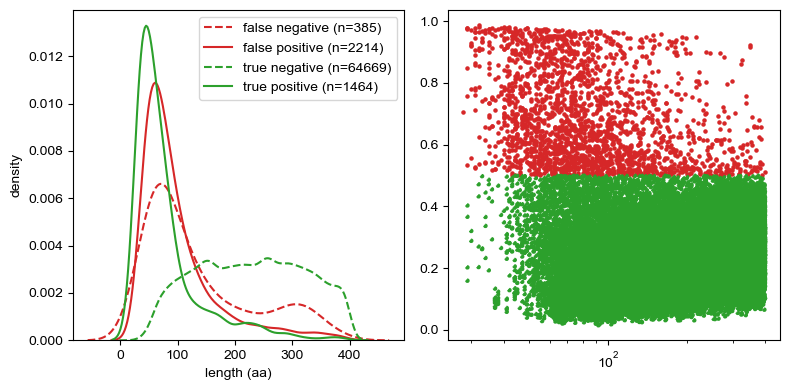

In [64]:
# I am mainly worried about the things that the model has predicted to be wrong, but are actually correct. 
# It does seem to have mainly just learned length. 

error_types = np.where((pred_out_df.filter_balance_classes_and_lengths_label == 1) & (pred_out_df.label == 0), 'false positive', '')
error_types = np.where((pred_out_df.filter_balance_classes_and_lengths_label == 1) & (pred_out_df.label == 1), 'true positive', error_types)
error_types = np.where((pred_out_df.filter_balance_classes_and_lengths_label == 0) & (pred_out_df.label == 1), 'false negative', error_types)
error_types = np.where((pred_out_df.filter_balance_classes_and_lengths_label == 0) & (pred_out_df.label == 0), 'true negative', error_types)
pred_out_df['error_type'] = error_types

kwargs = dict()
kwargs['false positive'] = {'color':'tab:red'}
kwargs['true positive'] = {'color':'tab:green'}
kwargs['false negative'] = {'color':'tab:red', 'ls':'--'}
kwargs['true negative'] = {'color':'tab:green', 'ls':'--'}

fig, axes = plt.subplots(ncols=2, layout='tight', figsize=(8, 4))

ax = axes[0]
for error_type, df in pred_out_df.groupby('error_type'):
    sns.kdeplot(df.seq.apply(len), label=f'{error_type} (n={len(df)})', **kwargs[error_type], ax=ax)
ax.legend()
ax.set_ylabel('density')
ax.set_xlabel('length (aa)')

ax = axes[1]
# Does this have something to do with the truncation sizes of the false positives versus true positives, or is it really just length?

for error_type in ['false positive', 'true negative']:
    df = pred_out_df[pred_out_df.error_type == error_type]
    diffs = [((row.ref_stop - row.ref_start) - (row.stop - row.stop)) // 3 for row in df.itertuples()]
    ref_lengths = [(row.ref_stop - row.ref_start) // 3 for row in df.itertuples()] 
    lengths = [(row.stop - row.start) // 3 for row in df.itertuples()] 
    ax.scatter(lengths, df.filter_balance_classes_and_lengths_output_1,  s=5, **kwargs[error_type])
ax.set_xscale('log')
plt.show()

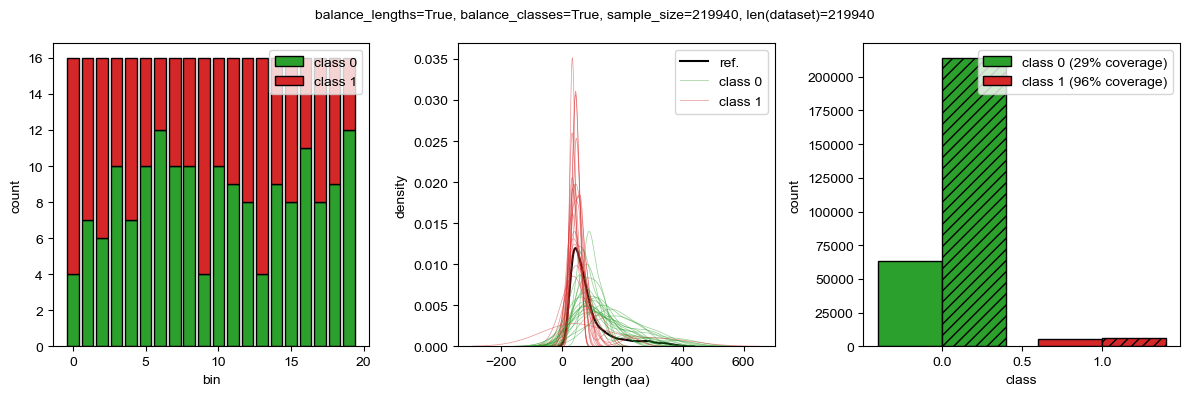

In [39]:
model = Classifier.load('../models/filter_balance_classes_and_lengths.pkl')
model.sampler.plot()

In [62]:
train_df = pd.read_csv('../data/filter_dataset_train.csv', index_col=0)
test_df = pd.read_csv('../data/filter_dataset_test.csv', index_col=0)

x_train, y_train = train_df.seq.apply(len).values, train_df.label.values
x_test, y_test = test_df.seq.apply(len).values, test_df.label.values

model = LogisticRegression(class_weight='balanced', C=0.001, tol=1e-8)
model.fit(x_train.reshape(-1, 1), y_train)

y_test_pred = model.predict(x_test.reshape(-1, 1))
y_train_pred = model.predict(x_train.reshape(-1, 1))

print('Balanced test accuracy:', balanced_accuracy_score(y_test, y_test_pred.ravel()))
print('Balanced train accuracy:', balanced_accuracy_score(y_train, y_train_pred.ravel()))

Balanced test accuracy: 0.7958396559282479
Balanced train accuracy: 0.7948956639028347


In [56]:
model.n_iter_

array([18], dtype=int32)